<a href="https://colab.research.google.com/github/nehadubey1205/NLP-college/blob/main/BulllysentEmo_SVM_LOGI_NAIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

import re 
import nltk 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.model_selection import train_test_split
from time import time

import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from google.colab import files
from matplotlib import pyplot as plt
import pandas as pd
import io
from sklearn.metrics import classification_report
import pickle

https://towardsdatascience.com/how-to-detect-and-translate-languages-for-nlp-project-dfd52af0c3b5
https://medium.com/@Jonathan_Guerra/classify-text-by-language-in-a-column-of-dataframe-with-python-nlp-process-14eee2ad82e

In [ ]:
data = pd.read_csv(r'/content/Bully_Sent_Emo_IEEEIC_6084.csv')

In [ ]:
data.head()

,Tweets,Processed_Tweets,Bully_Label,Sentiment_label,Emotion_label
0,Teri maa ki chut me Shivsena ka lund gaya kya,Teri maa ki chut me Shivsena ka lund gaya kya,1,Negative,Anger
1,Han muje pata hai teri maa ka ke gufa me jati thi,Han muje pata hai teri maa ka ke gufa me jati thi,1,Negative,Others
2,Tum kaha se aa gye bhai tumlog toh saree pehen...,Tum kaha se aa gye bhai tumlog toh saree pehen...,0,Neutral,Others
3,Koi moti🙊kisi ki besti😁 baisn ka or channey ki...,Koi motikisi ki besti baisn ka or channey ki d...,1,Negative,Disgust
4,Rahul kanwal aaj nanga hoke road per nachega 😂,Rahul kanwal aaj nanga hoke road per nachega,1,Negative,Disgust


In [ ]:
data = data.apply(lambda x: x.astype(str).str.lower())

In [ ]:
data.head(2)

,Tweets,Processed_Tweets,Bully_Label,Sentiment_label,Emotion_label
0,teri maa ki chut me shivsena ka lund gaya kya,teri maa ki chut me shivsena ka lund gaya kya,1,negative,anger
1,han muje pata hai teri maa ka ke gufa me jati thi,han muje pata hai teri maa ka ke gufa me jati thi,1,negative,others


In [ ]:
data['Sentiment_label'].value_counts()

negative    3227
positive    1530
neutral     1327
Name: Sentiment_label, dtype: int64

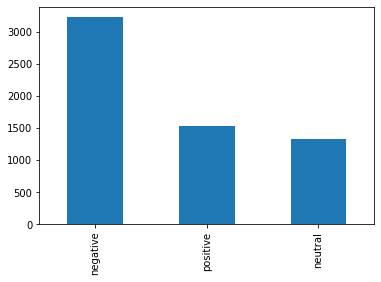

In [ ]:
#data = data(np.random.rand(10, 4), columns=['Bully_Label',	'Sentiment_label','Emotion_label'])
df = pd.DataFrame(data, columns=['Bully_Label',	'Sentiment_label','Emotion_label'])
#df.plot(x="Emotion_label", y=['Bully_Label'], kind="bar", figsize=(9, 8))
#[1261]: df2.plot(kind='bar');


df['Sentiment_label'].value_counts().plot(kind='bar')

In [ ]:
data['Bully_Label'].value_counts()# positive and neutral =0 , negative =1

1    3050
0    3034
Name: Bully_Label, dtype: int64

In [ ]:
df['Emotion_label'].value_counts()

others       1735
disgust      1678
happiness    1367
anger         900
sadness       254
surprise      114
fear           36
Name: Emotion_label, dtype: int64

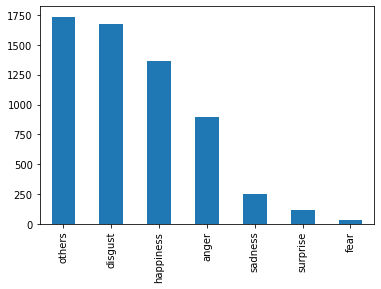

In [ ]:
df['Emotion_label'].value_counts().plot(kind='bar')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084 entries, 0 to 6083
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Tweets            6084 non-null   object
 1   Processed_Tweets  6084 non-null   object
 2   Bully_Label       6084 non-null   object
 3   Sentiment_label   6084 non-null   object
 4   Emotion_label     6084 non-null   object
dtypes: object(5)
memory usage: 237.8+ KB


In [ ]:
data.isnull().sum()

Tweets              0
Processed_Tweets    0
Bully_Label         0
Sentiment_label     0
Emotion_label       0
dtype: int64

In [ ]:
from collections import Counter

Tweets = data.Tweets.str.cat(sep=' ') 

freq = Counter(Tweets.split()).most_common(25)
print(freq)

[('hai', 2248), ('ka', 1665), ('ki', 1641), ('to', 1526), ('ko', 1174), ('ke', 1131), ('teri', 1111), ('hi', 1090), ('maa', 1043), ('se', 971), ('bhi', 957), ('randi', 937), ('ho', 884), ('me', 786), ('aur', 774), ('khubsurat', 682), ('is', 681), ('k', 643), ('the', 629), ('nahi', 605), ('and', 574), ('ye', 558), ('beautiful', 555), ('tu', 541), ('a', 521)]


In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
chars_hindi = [chr(c) for c in range(0x0900, 0x097f)]

In [ ]:
df_hindi = data[data.Processed_Tweets.str.contains('|'.join(chars_hindi))]

In [ ]:
df_hindi.tail(2)

,Tweets,Processed_Tweets,Bully_Label,Sentiment_label,Emotion_label
6038,भारत की इन जगहों के प्राकृतिक सौंदर्य को देखकर...,भारत की इन जगहों के प्राकृतिक सौंदर्य को देखकर...,0,positive,happiness
6083,"इश्क़ में थे जब,\nवादा हमारा,\nदावा भी हमारा,\...",इश्क़ में थे जबवादा हमारादावा भी हमाराधोखा उनक...,0,neutral,sadness


In [ ]:
# here apart from devnagirir common stop word, I have also added barakadi i.e. k ka ki kee kukoo etc.
line = "पर इन वह यिह वुह जिन्हें जिन्हों तिन्हें तिन्हों किन्हों किन्हें इत्यादि द्वारा इन्हें इन्हों उन्हों बिलकुल निहायत ऱ्वासा इन्हीं उन्हीं उन्हें इसमें जितना दुसरा कितना दबारा साबुत वग़ैरह दूसरे कौनसा लेकिन होता करने किया लिये अपने नहीं दिया इसका करना वाले सकते इसके सबसे होने करते बहुत वर्ग करें होती अपनी उनके कहते होते करता उनकी इसकी सकता रखें अपना उसके जिसे तिसे किसे किसी काफ़ी पहले नीचे बाला यहाँ जैसा जैसे मानो अंदर भीतर पूरा सारा होना उनको वहाँ वहीं जहाँ जीधर उनका इनका ﻿के हैं गया बनी एवं हुआ साथ बाद लिए कुछ कहा यदि हुई इसे हुए अभी सभी कुल रहा रहे इसी उसे जिस जिन तिस तिन कौन किस कोई ऐसे तरह किर साभ संग यही बही उसी फिर मगर का एक यह से को इस कि जो कर मे ने तो ही या हो था तक आप ये थे दो वे थी जा ना उस एस पे उन सो भी और घर तब जब अत व न क	का	कि	की	कु	कू	कृ	के	कै	को	कौ	कं	कः ख	खा	खि	खी	खु	खू	खृ	खे	खै	खो	खौ	खं	खः ग	गा	गि	गी	गु	गू	गृ	गे	गै	गो	गौ	गं	गः घ	घा	घि	घी	घु	घू	घृ	घे	घै	घो	घौ	घं	घः च	चा	चि	ची	चु	चू	चृ	चे	चै	चो	चौ	चं	चः छ	छा	छि	छी	छु	छू	छृ	छे	छै	छो	छौ	छं	छः ज	जा	जि	जी	जु	जू	जृ	जे	जै	जो	जौ	जं	जः झ	झा	झि	झी	झु	झू	झृ	झे	झै	झो	झौ	झं	झः ट	टा	टि	टी	टु	टू	टृ	टे	टै	टो	टौ	टं	टः ठ	ठा	ठि	ठी	ठु	ठू	ठृ	ठे	ठै	ठो	ठौ	ठं	ठः ड	डा	डि	डी	डु	डू	डृ	डे	डै	डो	डौ	डं	डः ढ	ढा	ढि	ढी	ढु	ढू	ढृ	ढे	ढै	ढो	ढौ	ढं	ढः ण	णा	णि	णी	णु	णू	णृ	णे	णै	णो	णौ	णं	णः त	ता	ति	ती	तु	तू	तृ	ते	तै	तो	तौ	तं	तः थ	था	थि	थी	थु	थू	थृ	थे	थै	थो	थौ	थं	थः द	दा	दि	दी	दु	दू	दृ	दे	दै	दो	दौ	दं	दः ध	धा	धि	धी	धु	धू	धृ	धे	धै	धो	धौ	धं	धः न	ना	नि	नी	नु	नू	नृ	ने	नै	नो	नौ	नं	नः प	पा	पि	पी	पु	पू	पृ	पे	पै	पो	पौ	पं	पः फ	फा	फि	फी	फु	फू	फृ	फे	फै	फो	फौ	फं	फः ब	बा	बि	बी	बु	बू	बृ	बे	बै	बो	बौ	बं	बः भ	भा	भि	भी	भु	भू	भृ	भे	भै	भो	भौ	भं	भः म	मा	मि	मी	मु	मू	मृ	मे	मै	मो	मौ	मं	मः य	या	यि	यी	यु	यू	यृ	ये	यै	यो	यौ	यं	यः र	रा	रि	री	रु	रू	रृ	रे	रै	रो	रौ	रं	रः ल	ला	लि	ली	लु	लू	लृ	ले	लै	लो	लौ	लं	लः ळ	ळा	ळि	ळी	ळु	ळू	ळृ	ळे	ळै	ळो	ळौ	ळं	ळः व	वा	वि	वी	वु	वू	वृ	वे	वै	वो	वौ	वं	वः श	शा	शि	शी	शु	शू	शृ	शे	शै	शो	शौ	शं	शः ष	षा	षि	षी	षु	षू	षृ	षे	षै	षो	षौ	षं	षः स	सा	सि	सी	सु	सू	सृ	से	सै	सो	सौ	सं	सः ह	हा	हि	ही	हु	हू	हृ	हे	है	हो	हौ"

In [ ]:
import nltk
nltk.download('punkt')
 
#string = "This is a sentence"
lst = nltk.word_tokenize(line)
print(lst)

['पर', 'इन', 'वह', 'यिह', 'वुह', 'जिन्हें', 'जिन्हों', 'तिन्हें', 'तिन्हों', 'किन्हों', 'किन्हें', 'इत्यादि', 'द्वारा', 'इन्हें', 'इन्हों', 'उन्हों', 'बिलकुल', 'निहायत', 'ऱ्वासा', 'इन्हीं', 'उन्हीं', 'उन्हें', 'इसमें', 'जितना', 'दुसरा', 'कितना', 'दबारा', 'साबुत', 'वग़ैरह', 'दूसरे', 'कौनसा', 'लेकिन', 'होता', 'करने', 'किया', 'लिये', 'अपने', 'नहीं', 'दिया', 'इसका', 'करना', 'वाले', 'सकते', 'इसके', 'सबसे', 'होने', 'करते', 'बहुत', 'वर्ग', 'करें', 'होती', 'अपनी', 'उनके', 'कहते', 'होते', 'करता', 'उनकी', 'इसकी', 'सकता', 'रखें', 'अपना', 'उसके', 'जिसे', 'तिसे', 'किसे', 'किसी', 'काफ़ी', 'पहले', 'नीचे', 'बाला', 'यहाँ', 'जैसा', 'जैसे', 'मानो', 'अंदर', 'भीतर', 'पूरा', 'सारा', 'होना', 'उनको', 'वहाँ', 'वहीं', 'जहाँ', 'जीधर', 'उनका', 'इनका', '\ufeffके', 'हैं', 'गया', 'बनी', 'एवं', 'हुआ', 'साथ', 'बाद', 'लिए', 'कुछ', 'कहा', 'यदि', 'हुई', 'इसे', 'हुए', 'अभी', 'सभी', 'कुल', 'रहा', 'रहे', 'इसी', 'उसे', 'जिस', 'जिन', 'तिस', 'तिन', 'कौन', 'किस', 'कोई', 'ऐसे', 'तरह', 'किर', 'साभ', 'संग', 'यही', 'बही', 'उसी', 'फिर

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data = data[~data.Tweets.str.contains('|'.join(lst))]
# through this , I have dropped all rows which was conatining devnagiri word

In [ ]:
data.shape

(5741, 5)

In [ ]:
data.tail(2)

,Tweets,Processed_Tweets,Bully_Label,Sentiment_label,Emotion_label
6081,khatna pe to bol diya ek baat bata upar wala t...,khatna pe to bol diya ek baat bata upar wala t...,1,negative,others
6082,chal be bhadwe sanghi.. teri maa ki choot me g...,chal be bhadwe sanghi teri maa ki choot me gho...,1,negative,disgust


In [ ]:
from sklearn.model_selection import train_test_split

X = data.Processed_Tweets.values
y = data.Bully_Label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [ ]:
''' # Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['Tweets',	'Processed_Tweets',	'Sentiment_label',	'Emotion_label']]

# Display 5 samples from the test data
test_data.sample(5) '''

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
# Uncomment to download "stopwords"
# nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('hinglish')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
#nb.predict(X_val_tfidf.iloc[[0]])

MultinomialNB()

In [ ]:
from sklearn import metrics
predicted = nb.predict(X_val_tfidf)
accuracy_score = metrics.accuracy_score(predicted, y_val)
print("Accuracuy Score: ",accuracy_score)

Accuracuy Score:  0.8486956521739131


The end for naive bayes . we will work on  SVM

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

another approch using BERT
https://github.com/ZeroxTM/BERT-CNN-Fine-Tuning-For-Hate-Speech-Detection-in-Online-Social-Media/blob/main/BertCnnFinal.ipynb

https://github.com/mohd-faizy/06P_Sentiment-Analysis-With-Deep-Learning-Using-BERT/blob/master/01_Sentiment_Analysis_with_Deep_Learning_using_BERT.ipynb

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
from sklearn.metrics import classification_report
#y_pred = model.predict(x_test)
print (classification_report (y_val, predicted))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       273
           1       0.82      0.91      0.86       302

    accuracy                           0.85       575
   macro avg       0.85      0.85      0.85       575
weighted avg       0.85      0.85      0.85       575



***LOGISTIC REGRESSION***

In [ ]:
#from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [134]:
# train models
from sklearn.linear_model import LogisticRegression

# logistic regression
model1 = LogisticRegression()


In [142]:
model1.fit(X_train_tfidf, y_train)

#predict prob
pred_prob1 = model1.predict_proba(X_val_tfidf)



In [137]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_val, pred_prob1[:,1], pos_label=1)
#fpr2, tpr2, thresh2 = roc_curve(y_val, predicted[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


In [139]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_val, pred_prob1[:,1])
#auc_score2 = roc_auc_score(y_val, pred_prob2[:,1])

print(auc_score1)

0.9185284913761735


***SVM***

In [149]:
from sklearn import model_selection, svm
#from sklearn.metrics import accuracy_score

In [150]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_val_tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_val)*100)

SVM Accuracy Score ->  83.47826086956522
